In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image, Markdown, display
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
def show_sns_plot(ax, title, xlabel, ylabel):
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)

    plt.show()

# A/B Test of Cookie Cats Gate Experiment
by Andrius Drazdys | adrazd

## Introduction
*Cookie Cats* is a mobile game by [_Tactile Entertainment_](https://tactilegames.com/). It is a casual puzzle game similar by concept to classic *match-3* games, however with additional strategy twist, where in order to beat a level player has to collect cookies of certain color and shape within limited number of moves. Depending how good the player is in a specific level, there is an award of 1, 2 or 3 stars. Thus players aiming for perfection may play one level several times to get a perfect score.

After making some progress through the levels, the player faces a block in a form of a locked gate (marked **1** in the picture below). In the version we have tested in order to understand the experiment, the first gate blocked our progress after completing level 40. In order to pass the gate player has two options:
1. purchase keys to unlock the gate for in-game coins (**2**):
   - by completing 40 levels we were allocated 14 coins (**3**) randomly, so we are still 56 coins short;
   - coins can be purchased with real money (**4**) or acquired by watching ads (1 coin for 40-60 seconds ad).
2. win keys by beating extra levels, which are more complex than the regular ones (**5**). In addition, after winning a key the player is required to wait 4 hours (**6**) before an attempt to play for next key is allowed.

For clarity it should be noted, that we have not designed the experiment, but just received a dataset from [_kaggle.com_](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats). An experiment was conducted by the creators of the game and involved changing location of the first blocking gate in the game from level 30 (*control group*)to level 40 (*experiment group*).

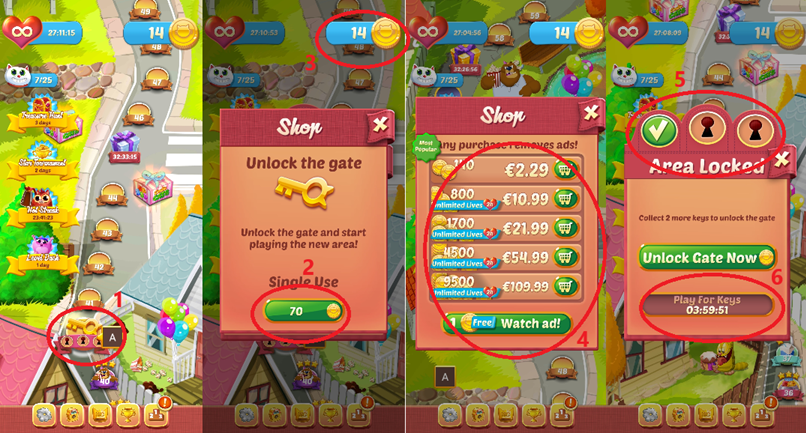

In [3]:
img = Image(filename="pictures/cookie_cats_gate_40.png")
display(img)

## Goal of the Project
Our goal is to provide valuable insights and actionable recommendations to the game creators based on the A/B tests conducted on relevant metrics from the provided dataset. Specifically, we aim to determine whether relocating the blocking gate from level 30 to level 40 affects user behavior.

## Statistical Significance and Confidence Level
In this project, all statistical calculations and analyses are performed with a confidence level of 95%, corresponding to an alpha (α) value of 0.05. This means that we accept a 5% probability of committing a *Type I error* (rejecting a true null hypothesis).

It is important to note that this confidence level is maintained throughout the project unless otherwise indicated in specific analyses or sections. This approach ensures consistency in evaluating the statistical significance of the results and helps provide a clear framework for interpreting the findings.

Any deviation from this standard, if any, is explicitly stated in the relevant sections of the project to maintain transparency and clarity in the statistical methodologies employed.

## Conclusions
Throughout our analysis we have identified several potential problems related to the design of experiment and the dataset, such as sample ratio mismatch, lack of clarity in definitions and inconsistent metric timelines. For a detailed explanation please refer to *Chapter 3* of this notebook.

Taking above into consideration we have come to the following conclusions:
1. We are 95% confident that the difference between rates of 1-day retention between the versions is not statistically significant.
2. We are 95% confident that the difference in 7-day retention rates is statistically significant, with users in the experiment group (`gate_40`) showing smaller 7-day retention rates.
3. We cannot definitively conclude whether the differences in retention rates are due to variations in software versions.

## Recommendations
1. We recommend designing a new experiment that clearly accounts for users who have reached the relevant features (e.g. `gate_30` and `gate_40`). This new experiment should carefully consider the timeline of data collected. Additionally, following basic guidelines for designing experiments will help avoid potential issues like *Sample Ratio Mismatch (SRM)*, as observed in our dataset.
2. We recommend keeping the original version (`gate_30`) until a new experiment has been designed and the data from that experiment has been analyzed.

## 1. EDA

In [4]:
df = pd.read_csv("datasets/cookie_cats.csv")

In [5]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [6]:
df.shape

(90189, 5)

The dataset contains the following 5 features:
- userid (90,189 records)
- version
- sum_gamerounds
- retention_1
- retention_7

Feature `userid` contains unique user id.<br>
Feature `version` contains information about groups of the experiment (`gate_30` - *control group* and `gate_40` - *experiment group*). Based on description of the dataset, users were assigned to either of the groups randomly, when installing the game.<br>
Feature `sum_gamerounds` is a total *gamerounds* by a user during first 14 days after installation. Definition of a *gameround* is unclear, as it can be either number of attempts by the player to beat the level, or number of levels beaten by the player, or even number of times the player has launched the game. Given these considerations, it is unlikely that analyzing this feature would yield actionable insights.<br>
Features `retention_1` and `retention_7` contain boolean values, meaning whether player has returned to the game in 1 day and or in 7 days (correspondingly) after the installation.

In [7]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

Now that we have made sure that the dataset does not contain duplicate entries and `NaN` values, i.e. does not require cleaning, let's take a closer look at the data itself.

### 1.1 Gamerounds

In [9]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In our dataset of 90,189 records for `sum_gamerounds`, the mean stands at 52, with a standard deviation of 195. However, the median is just 16, and the third quartile is at 51, very close to the mean. This highlights a significant right-skew in the distribution, indicating that most users play fewer game rounds, while a small number play a disproportionately large number of rounds. Distribution of 200 most frequent values of *Total Gamerounds* is shown in the figure below.

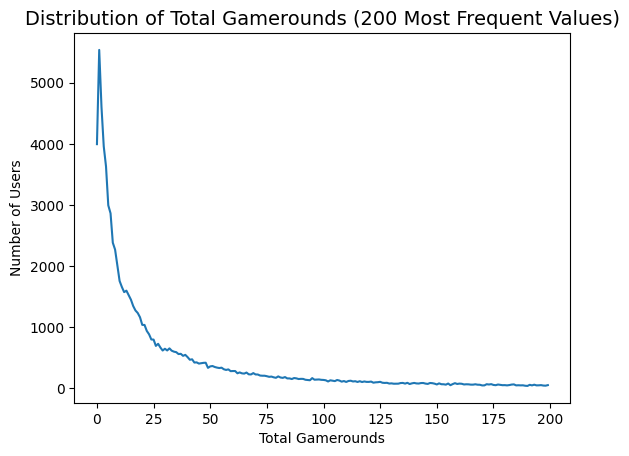

In [10]:
sum_gamerounds_distribution = df.groupby("sum_gamerounds")["userid"].count()

distribution_plot = sns.lineplot(data=sum_gamerounds_distribution.head(200))
show_sns_plot(
    distribution_plot,
    title="Distribution of Total Gamerounds (200 Most Frequent Values)",
    xlabel="Total Gamerounds",
    ylabel="Number of Users",
);

### 1.2 Retention 
1-day retention and 7-day retention are crucial metrics for mobile apps as they provide insights into user engagement and the app’s ability to retain users beyond the initial download phase (source articles: [Mobile App Retention](https://www.businessofapps.com/guide/mobile-app-retention/), [Mobile App Retention Guide](https://nestify.io/blog/mobile-app-retention-guide-what-why-and-best-practice/)).

- 1-Day Retention
  - Initial Engagement: This metric shows the percentage of users who return to the app the day after they install it. A high 1-day retention rate indicates that users find the app immediately valuable or engaging.
  - First Impressions: It helps in understanding the effectiveness of the app’s onboarding process and initial user experience.
- 7-Day Retention
  - Sustained Interest: This metric measures the percentage of users who continue to use the app a week after installation. It reflects whether the app can maintain user interest beyond the initial curiosity.
  - User Value: A higher 7-day retention rate suggests that users are finding ongoing value in the app, which is crucial for long-term success.
- Why These Metrics Matter
  - User Acquisition vs. Retention: Acquiring new users is often more expensive than retaining existing ones. High retention rates can lead to a more sustainable user base and better return on investment.
  - Revenue Potential: Users who stay longer are more likely to make in-app purchases or subscribe to premium features, directly impacting revenue.
Feedback and Improvement: Retention metrics help identify areas for improvement in the app, such as user interface issues or lack of engaging content.

In [11]:
retention_by_version = df.groupby("version")[["retention_1", "retention_7"]].mean()
retention_by_version

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


As shown in the table above, 1-day retention rates and 7-day retention rates seem similar between the *control* and *experiment* groups. 1-day retention in *control group* is 44.8%, whereas in *experiment* group it is 44.2%. Corresponding 7-day retention rates are 19% and 18.2%.

As retention rates are critical performance indicators for mobile applications, we have selected these metrics for our A/B testing. Specifically, our focus will be on 1-day retention (`retention_1`) and 7-day retention (`retention_7`) to evaluate how moving the gate from level 30 to level 40 has influenced user engagement.

## 2. A/B Testing
### 2.1 Preparation of Data

In [12]:
ab_test_agg = df.groupby("version").agg(
    total_count=("userid", "count"),
    retention_1_rate=("retention_1", "mean"),
    retention_7_rate=("retention_7", "mean"),
)

total_count = df["userid"].count()
total_retention_1_rate = df["retention_1"].mean()
total_retention_7_rate = df["retention_7"].mean()

total_sample = pd.DataFrame(
    {
        "retention_1_rate": [total_retention_1_rate],
        "retention_7_rate": [total_retention_7_rate],
        "total_count": [total_count],
    },
    index=["total_sample"],
)

ab_test_agg = pd.concat([ab_test_agg, total_sample])

ab_test_agg

,total_count,retention_1_rate,retention_7_rate
gate_30,44700,0.448188,0.190201
gate_40,45489,0.442283,0.182000
total_sample,90189,0.445210,0.186065


We have aggregated the data by version and calculated retention rates both for `retention_1` and `retention_7`.

Total sample size is 90,189, split into *control group* (`gate_30`) and *experiment group* (`gate_40`) with 44,700 and 45,489 respectively.

In [13]:
p_control_1 = ab_test_agg["retention_1_rate"].iloc[0]
p_experiment_1 = ab_test_agg["retention_1_rate"].iloc[1]

p_control_7 = ab_test_agg["retention_7_rate"].iloc[0]
p_experiment_7 = ab_test_agg["retention_7_rate"].iloc[1]

n_control = ab_test_agg["total_count"].iloc[0]
n_experiment = ab_test_agg["total_count"].iloc[1]
n_sample = ab_test_agg["total_count"].iloc[2]

### 2.2 Sanity Check
We will perform the *Sanity Check* to ensure that the control and experiment groups are close to equal in size, i.e. there is no *Sample Ratio Mismatch*. Please be reminded, that the randomness of the total sample itself has been declared by the source of the dataset.

$H_{0} : n_{\text{control}} \approx n_{\text{experiment}}$<br>
$H_{1} : n_{\text{control}} \neq n_{\text{experiment}}$<br>

Let's investigate our null hypothesis, $H_{0}$, by performing $\chi^2$ test on the proportion sizes.

In [14]:
observed = [n_control, n_experiment]
expected = [45094, 45095]

chi2_stat, p_value = stats.chisquare(observed, expected)

print(f"Chi-square Statistic: {chi2_stat:.06}, p-value: {p_value:.06}")

Chi-square Statistic: 6.88492, p-value: 0.0086926


The calculated *Chi-square Statistic* exceeds the critical value of 3.84 for α = 0.05, and the computed *p-value* (0.0087) is lower than α. Therefore, we reject the null hypothesis, indicating that the proportions differ significantly from the expected 50/50 split. This raises concerns about the randomness of the sample and the potential for bias, suggesting that our findings should be interpreted with caution.

Taking the above into consideration, we will use **bootstrapping** on our sample, as bootstrapping usually does not strictly rely on the sample size.

### 2.3 Bootstrap

As discussed in *Chapter 2.2*, our dataset is exposed to risks of bias, which prevents us from applying the bootstrapping technique to the entire sample. Instead, we will utilize **stratified bootstrapping**. We have divided the original dataset into two **strata** based on the version. In each iteration (1,000 iterations in total), we will generate a random sample with replacement of 25,000 records from each **stratum**, recording the means of `retention_1` and `retention_7`. Subsequently, we will analyze these means to determine if there is a significant difference between the *groups*.

In [15]:
np.random.seed(2024)

sample_size = 25000

bootstrap_control_r1 = []
bootstrap_experiment_r1 = []
bootstrap_control_r7 = []
bootstrap_experiment_r7 = []

for i in range(1000):
    control_sample = df[df["version"] == "gate_30"].sample(n=sample_size, replace=True)
    experiment_sample = df[df["version"] == "gate_40"].sample(
        n=sample_size, replace=True
    )
    bootstrap_control_r1.append(control_sample["retention_1"].mean())
    bootstrap_experiment_r1.append(experiment_sample["retention_1"].mean())
    bootstrap_control_r7.append(control_sample["retention_7"].mean())
    bootstrap_experiment_r7.append(experiment_sample["retention_7"].mean())

bootstrap_df = pd.DataFrame(
    {
        "bootstrap_control_r1": bootstrap_control_r1,
        "bootstrap_experiment_r1": bootstrap_experiment_r1,
        "bootstrap_control_r7": bootstrap_control_r7,
        "bootstrap_experiment_r7": bootstrap_experiment_r7,
    }
)

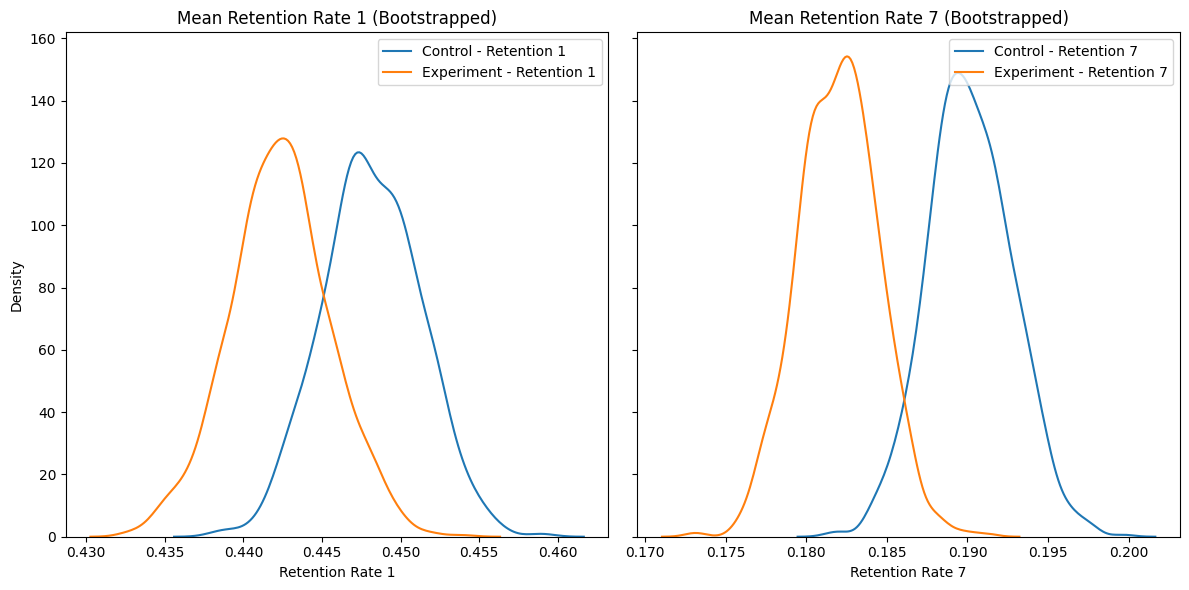

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.kdeplot(
    bootstrap_df["bootstrap_control_r1"], label="Control - Retention 1", ax=axes[0]
)
sns.kdeplot(
    bootstrap_df["bootstrap_experiment_r1"],
    label="Experiment - Retention 1",
    ax=axes[0],
)
axes[0].set_title("Mean Retention Rate 1 (Bootstrapped)")
axes[0].set_xlabel("Retention Rate 1")
axes[0].legend(loc="upper right")

sns.kdeplot(
    bootstrap_df["bootstrap_control_r7"], label="Control - Retention 7", ax=axes[1]
)
sns.kdeplot(
    bootstrap_df["bootstrap_experiment_r7"],
    label="Experiment - Retention 7",
    ax=axes[1],
)
axes[1].set_title("Mean Retention Rate 7 (Bootstrapped)")
axes[1].set_xlabel("Retention Rate 7")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [17]:
bootstrap_df.mean()

bootstrap_control_r1       0.448156
bootstrap_experiment_r1    0.442319
bootstrap_control_r7       0.190172
bootstrap_experiment_r7    0.182012
dtype: float64

As we see, the means of bootstrapped retention rates for both control and experiment groups are very close to means of retention rates from the original data.

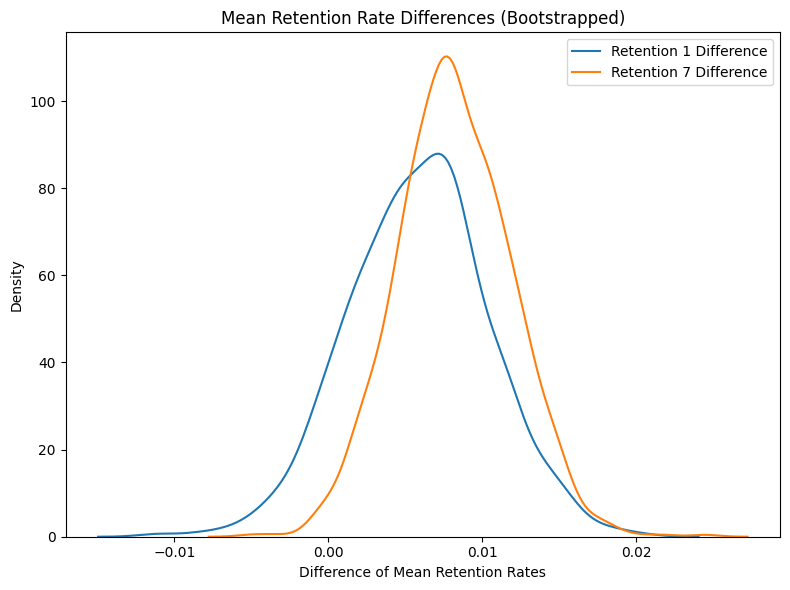

In [18]:
diff_control_exp_r1 = (
    bootstrap_df["bootstrap_control_r1"] - bootstrap_df["bootstrap_experiment_r1"]
)
diff_control_exp_r7 = (
    bootstrap_df["bootstrap_control_r7"] - bootstrap_df["bootstrap_experiment_r7"]
)

fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    diff_control_exp_r1,
    label="Retention 1 Difference",
    ax=ax,
)

sns.kdeplot(
    diff_control_exp_r7,
    label="Retention 7 Difference",
    ax=ax,
)

ax.set_title("Mean Retention Rate Differences (Bootstrapped)")
ax.set_xlabel("Difference of Mean Retention Rates")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

As shown in the above plot, distributions of retention rate difference means retain normality. Just to be sure, lets take a look at the QQ plots of both variables (plot below).

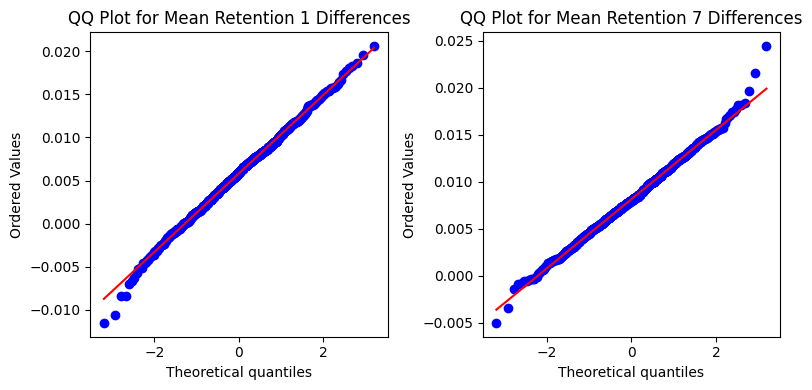

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

stats.probplot(diff_control_exp_r1, dist="norm", plot=ax1)
ax1.set_title("QQ Plot for Mean Retention 1 Differences")

stats.probplot(diff_control_exp_r7, dist="norm", plot=ax2)
ax2.set_title("QQ Plot for Mean Retention 7 Differences")

plt.tight_layout()
plt.show()

From the QQ plots above we have another proof of normality of distribution of mean differences for both `retention_1` and `retention_7`.

### 2.4 Hypothesis and Statistical Tests
Our project goal is to examine impact of new version of the app on the users. As described in Chapter 1.2, we have chosen retention rates as the key metrics for analysis. Here we raise the **null hypothesis** that means of respective retention rates do not differ, i.e. retention rates remain unchanged, regardless of the version. As an **alternative hypothesis** we have a statement that version change does have an impact on retention rates, i.e. means of respective retention rates are different depending on version. For brevity we will use abbreviations: **r1** for `retention_1` and **r7** for `retention_7`:

$H_{0(r1)} : \mu_{\text{control}(r1)} - \mu_{\text{experiment}(r1)} = 0$<br>
$H_{1(r1)} : \mu_{\text{control}(r1)} - \mu_{\text{experiment}(r1)} \neq 0$

$H_{0(r7)} : \mu_{\text{control}(r7)} - \mu_{\text{experiment}(r7)} = 0$<br>
$H_{1(r7)} : \mu_{\text{control}(r7)} - \mu_{\text{experiment}(r7)} \neq 0$

As already mentioned in *Chapter 2.2*, we have decided to use bootstrapped data for analysis. From the plots in Chapter 2.3 we can see, that the bootstrapped data is distributed normally, therefore we can use Z-test.

In [20]:
def bstrap_ztest(control_group, experiment_group, sample_size):
    mean_control = np.mean(control_group)
    mean_experiment = np.mean(experiment_group)

    diff_means = mean_experiment - mean_control

    count = [
        mean_control * sample_size,
        mean_experiment * sample_size,
    ]
    n_obs = [sample_size, sample_size]

    z_stat, p_value = proportions_ztest(count, n_obs)

    pooled_std = np.sqrt(
        (np.var(control_group) / sample_size) + (np.var(experiment_group) / sample_size)
    )

    z_alpha = 1.96
    ci_lower = diff_means - z_alpha * pooled_std
    ci_upper = diff_means + z_alpha * pooled_std

    print(f"Estimated Treatment Effect: {diff_means:.06}")
    print(f"p-value: {p_value:.06}")
    print(
        f"95% Confidence Interval for the Difference: [{ci_lower:.06}, {ci_upper:.06}]"
    )

    return diff_means, ci_lower, ci_upper

In [21]:
print("1-day retention:")
treatment_r1, ci_low_r1, ci_high_r1 = bstrap_ztest(
    bootstrap_control_r1, bootstrap_experiment_r1, sample_size
)

1-day retention:
Estimated Treatment Effect: -0.005837
p-value: 0.189152
95% Confidence Interval for the Difference: [-0.00589243, -0.00578157]


The experiment group shows a lower 1-day retention rate compared to the control group, with an estimated treatment effect suggesting a small decrease in retention (about 0.58% lower).
The p-value indicates that the result is not statistically significant at the 0.05 level (p-value for 1-day retention is 0.189), so we **fail to reject** the null hypothesis (H<sub>0(r1)</sub>).
Since the entire confidence interval is negative, it reinforces the finding that the experiment group has a lower retention rate than the control group.

In [22]:
print("7-day retention:")
treatment_r7, ci_low_r7, ci_high_r7 = bstrap_ztest(
    bootstrap_control_r7, bootstrap_experiment_r7, sample_size
)

7-day retention:
Estimated Treatment Effect: -0.0081606
p-value: 0.0190594
95% Confidence Interval for the Difference: [-0.00820521, -0.00811599]


The experiment group shows a lower 7-days retention rate compared to the control group, with an estimated treatment effect of about 0.82% lower.
The p-value of 0.0191 indicates that this result is statistically significant, meaning that we have strong evidence that there is a negative impact on player retention. We **reject** the null hypothesis (H<sub>0(r7)</sub>) for 7-day retention.
The confidence intervals are negative, so we have further support to the conclusion that the experiment group has a lower retention rate than the control group.

For visual illustration of treatment effects and respective confidence intervals please refer to the plot below.

In [23]:
treatment_effect_data = {
    "Retention": ["Retention 1", "Retention 7"],
    "Treatment Effect": [treatment_r1, treatment_r7],
    "Lower CI": [ci_low_r1, ci_low_r7],
    "Upper CI": [ci_high_r1, ci_high_r7],
}

retention_treatment_effect = pd.DataFrame(treatment_effect_data)

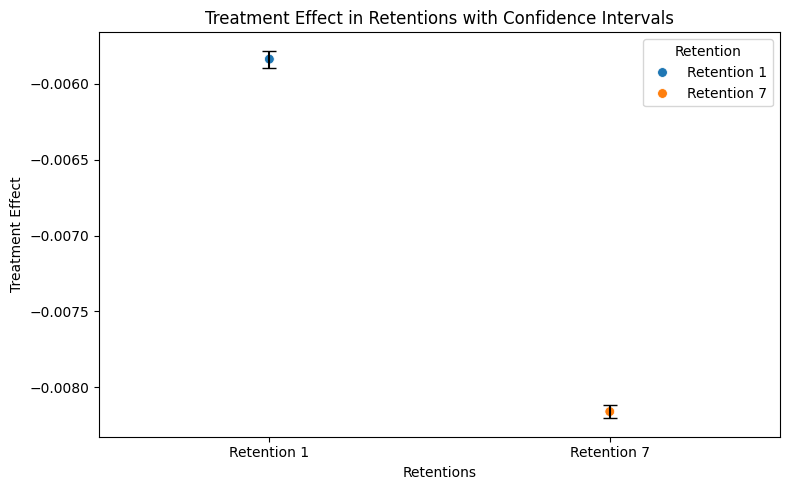

In [24]:
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=retention_treatment_effect,
    x="Retention",
    y="Treatment Effect",
    hue="Retention",
    s=50,
)

for index, row in retention_treatment_effect.iterrows():
    plt.errorbar(
        row["Retention"],
        row["Treatment Effect"],
        yerr=[
            [row["Treatment Effect"] - row["Lower CI"]],
            [row["Upper CI"] - row["Treatment Effect"]],
        ],
        fmt="none",
        c="black",
        capsize=5,
    )

plt.xlim(-0.5, 1.5)

plt.title("Treatment Effect in Retentions with Confidence Intervals")
plt.ylabel("Treatment Effect")
plt.xlabel("Retentions")

plt.tight_layout()
plt.show()

## 3. Potential Problems

Mainly due to irregularities in the design of the experiment, which resulted in the dataset, which we have analyzed, we have identified the following potential problems with the data:
1. There is a *Sample Ratio Mismatch (SRM)* between number of users in versions `gate_30` (control group) and `gate_40` (experiment group), which exposes the sample to risk of bias. Due to this we have used bootstrapping during our analysis instead of traditional analytical methods.
2. Data in `sum_gamerounds` is not clearly defined, thus it is not clear, which users have reached the *gates* and dropped out because of the "block" in the game, and which have dropped out for other reasons, than facing difficulties to progress in the game.
3. In the description of features of the dataset, `sum_gamerounds` is described as number of rounds user has played 14 days after installation, whereas maximum retention for which data is available in the dataset is 7 days (`retention_7`). Difference in timeline makes it impossible to analyze retention rates in connection with number of gamerounds.

## 4. Conclusions
Taking into consideration potential problems with the data, described in *Chapter 3*, we can state the following:
1. We are 95% confident that the difference between rates of 1-day retention between the versions is not statistically significant.
2. We are 95% confident that the difference in 7-day retention rates is statistically significant, with users in the experiment group (`gate_40`) showing smaller 7-day retention rates.
3. We cannot definitively conclude whether the differences in retention rates are due to variations in software versions.

## 5. Recommendations
1. We recommend designing a new experiment that clearly accounts for users who have reached the relevant features (e.g. `gate_30` and `gate_40`). This new experiment should carefully consider the timeline of data collected. Additionally, following basic guidelines for designing experiments will help avoid potential issues like *Sample Ratio Mismatch (SRM)*, as observed in our dataset.
2. We recommend keeping the original version (`gate_30`) until a new experiment has been designed and the data from that experiment has been analyzed.